In this file the linear multivariate model analysis will be performed.

In [79]:
# Manage imports

import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import grangercausalitytests


In [80]:
# Load data
df_btc = pd.read_csv('../data/btc_data.csv')
df_eth = pd.read_csv('../data/eth_data.csv')
df_sp500 = pd.read_csv('../data/sp500_data.csv')
df_vix = pd.read_csv('../data/vix_data.csv')
df_gold = pd.read_csv('../data/gold_data.csv')


In [ ]:
# Ensure consistent column names
for df in [df_btc, df_eth, df_sp500, df_vix, df_gold]:
    df.columns = df.columns.str.strip()

# Convert 'Date' to datetime
for df in [df_btc, df_eth, df_sp500, df_vix, df_gold]:
    df['Date'] = pd.to_datetime(df['Date'])

# Set index to 'Date'
for df in [df_btc, df_eth, df_sp500, df_vix, df_gold]:
    df.set_index('Date', inplace=True)

# Selecting only 'Close' prices and rename
df_btc = df_btc[['Close']].rename(columns={'Close': 'BTC'})
df_eth = df_eth[['Close']].rename(columns={'Close': 'ETH'})
df_sp500 = df_sp500[['Close']].rename(columns={'Close': 'SP500'})
df_vix = df_vix[['Close']].rename(columns={'Close': 'VIX'})
df_gold = df_gold[['Close']].rename(columns={'Close': 'GOLD'})

In [82]:
# Merging all dataframes on index (Date)
dfs = [df_btc, df_eth, df_sp500, df_gold]
df_merged = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), dfs)

# Forward-fill and backward-fill missing values
df_merged.ffill(inplace=True)
df_merged.bfill(inplace=True)

# Saving merged dataset to file
df_merged.to_csv('../data/merged_data.csv')

In [83]:
# Forward-fill then backward-fill missing values to ensure consistency
df_merged.ffill(inplace=True)
df_merged.bfill(inplace=True)

In [ ]:
# Transformation: Computing log returns to stabilize variance and help with stationarity
log_returns = np.log(df_merged / df_merged.shift(1)).dropna()

# Saving the log returns
log_returns.to_csv('../data/log_returns.csv')

In [86]:
# Vector Autoregression (VAR) Model

# Fitting the VAR model on the log returns
model = VAR(log_returns)

# Lag Order Selection using criteria AIC (Can also check BIC, HQIC, etc.)
lag_order_results = model.select_order(maxlags=15)
print("Lag Order Selection Criteria:")
print(lag_order_results.summary())

# Selecting the optimal lag based on AIC.
optimal_lag = lag_order_results.aic
print("Optimal Lag Order (BIC):", optimal_lag)

/Users/basteolafsen/opt/anaconda3/envs/crypto-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Lag Order Selection Criteria:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -33.10     -33.09*   4.230e-15      -33.09
1       -33.11      -33.08   4.183e-15     -33.10*
2       -33.11      -33.06   4.180e-15      -33.09
3       -33.11      -33.04   4.192e-15      -33.08
4       -33.11      -33.02   4.188e-15      -33.08
5       -33.11      -33.00   4.184e-15      -33.07
6       -33.11      -32.98   4.172e-15      -33.06
7       -33.11      -32.95   4.185e-15      -33.05
8       -33.11      -32.94   4.158e-15      -33.05
9       -33.11      -32.92   4.157e-15      -33.05
10      -33.11      -32.90   4.155e-15      -33.04
11     -33.12*      -32.88  4.140e-15*      -33.03
12      -33.12      -32.86   4.152e-15      -33.02
13      -33.12      -32.84   4.152e-15      -33.02
14      -33.12      -32.82   4.147e-15      -33.01
15      -33.11      -32.79   4.158e-15      -33.00
-

In [87]:
# Fitting the VAR model with optimal lag according to AIC
results_var = model.fit(optimal_lag)
print(results_var.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 04, Apr, 2025
Time:                     12:38:01
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -32.8820
Nobs:                     4930.00    HQIC:                  -33.0361
Log likelihood:           53837.8    FPE:                4.13460e-15
AIC:                     -33.1194    Det(Omega_mle):     3.98702e-15
--------------------------------------------------------------------
Results for equation BTC
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000958         0.000458            2.092           0.036
L1.BTC            0.033763         0.019150            1.763           0.078
L1.ETH           -0.074510         0.018267           -4.079           0.000
L

In [88]:
# Diagnostics: Check for residual autocorrelation using the Ljung-Box test
# Convert residuals to a DataFrame with proper column names and index
resid_df = pd.DataFrame(results_var.resid, 
                        index=log_returns.index[results_var.k_ar:], 
                        columns=log_returns.columns)

# Run Ljung-Box test on each column separately
for col in resid_df.columns:
    lb_test = acorr_ljungbox(resid_df[col], lags=[10], return_df=True)
    print(f"Ljung-Box Test for {col}:")
    print(lb_test)
    # Check the p-value
    if lb_test['lb_pvalue'].iloc[0] < 0.05:
        print(f"Reject null hypothesis: Significant autocorrelation in {col} residuals.")
    else:
        print(f"Fail to reject null hypothesis: No significant autocorrelation in {col} residuals.")
    print("\n")

#Interpretation of the Ljung-Box test results:
# The null hypothesis of the Ljung-Box test is that there is no autocorrelation in the residuals.
# If the p-value is less than 0.05, we reject the null hypothesis, indicating that there is significant autocorrelation.
# If the p-value is greater than 0.05, we fail to reject the null hypothesis, indicating that there is no significant autocorrelation.


Ljung-Box Test for BTC:
     lb_stat  lb_pvalue
10  0.038078        1.0
Fail to reject null hypothesis: No significant autocorrelation in BTC residuals.


Ljung-Box Test for ETH:
     lb_stat  lb_pvalue
10  0.064757        1.0
Fail to reject null hypothesis: No significant autocorrelation in ETH residuals.


Ljung-Box Test for SP500:
    lb_stat  lb_pvalue
10  1.68363    0.99824
Fail to reject null hypothesis: No significant autocorrelation in SP500 residuals.


Ljung-Box Test for GOLD:
     lb_stat  lb_pvalue
10  0.243893        1.0
Fail to reject null hypothesis: No significant autocorrelation in GOLD residuals.




In [89]:
# Checking the stability using eigenvalues (all should be less than 1 in absolute value)

# Computing eigenvalues from the companion matrix
coefs = results_var.coefs  # Coefficients of the VAR model
k = coefs.shape[1]  # Number of variables
p = coefs.shape[0]  # Number of lags
comp_matrix = np.zeros((k * p, k * p))  # Initialize companion matrix
comp_matrix[:k, :] = coefs.reshape(k, -1)  # Fill the first block with coefficients
if p > 1:
    comp_matrix[k:, :-k] = np.eye(k * (p - 1))  # Fill the lower diagonal with identity matrix

eigenvalues = np.linalg.eigvals(comp_matrix)

# Check if all eigenvalues are less than 1 in absolute value
stable = np.all(np.abs(eigenvalues) < 1)
print("Is the VAR model stable? (All eigenvalues < 1 in absolute value):", stable)


Is the VAR model stable? (All eigenvalues < 1 in absolute value): True


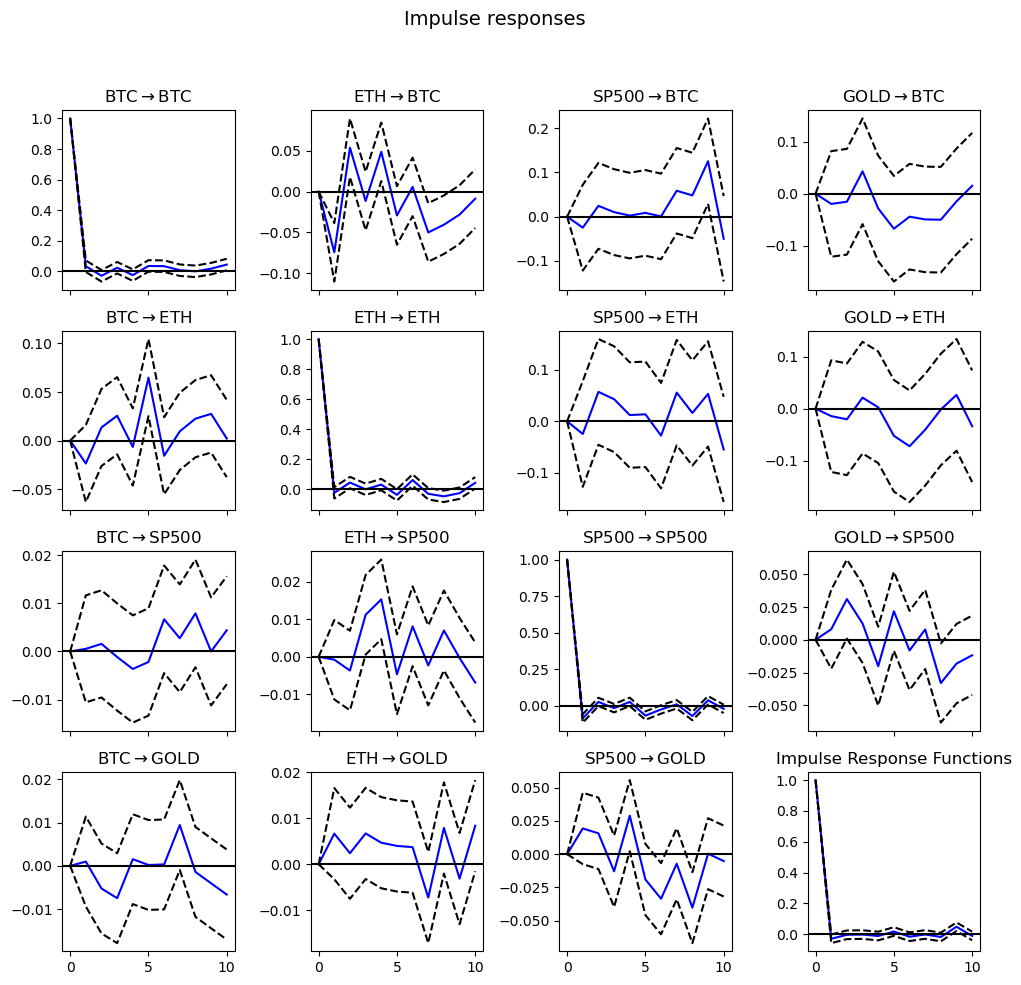

In [90]:
# Impulse Response Functions (IRFs)
irf = results_var.irf(10)  # 10 periods ahead
irf.plot(orth=False)
plt.title("Impulse Response Functions")


# Tidy up layout so titles/labels don’t overlap
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

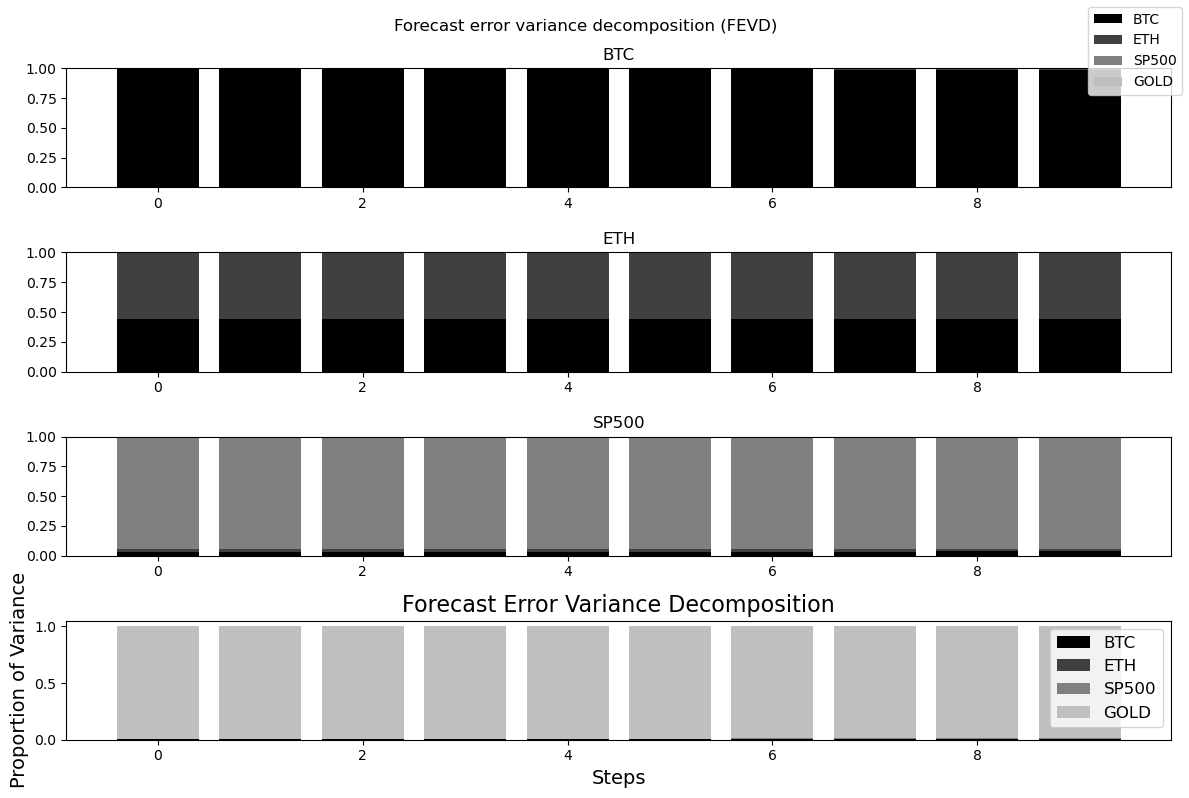

In [93]:
# FEVD analysis

fevd = results_var.fevd(10)  # 10 periods ahead
fevd.plot()
# Format plot better
fig = plt.gcf()
fig.set_size_inches(12, 8)  # Adjust figure size
plt.title("Forecast Error Variance Decomposition", fontsize=16)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Proportion of Variance", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()  # Ensure everything fits well
plt.show()

Assumptions:
The VAR model assumes linear relationships among the log return series.
All time series are stationary (log returns typically satisfy this).
Residuals are assumed to be uncorrelated (white noise).
Limitations:
External shocks or structural breaks are not explicitly modeled.
Multicollinearity among highly correlated variables may affect coefficient interpretability.
The model’s performance can be sensitive to the selected lag order and sample period.
Nonlinear interactions are not captured by a linear VAR framework.
Diagnostic Tests:
Use tests like Ljung-Box for autocorrelation and Jarque-Bera for normality of residuals to validate model assumptions.